# Mars Seismic Data Visualization


This is a notebook to download and visualize Mars seismic event data from the xxxx 3-component seismiometer

Here is a great readme on downloading the data and formatting it from NASA: https://pds-geosciences.wustl.edu/insight/urn-nasa-pds-insight_seis/readme.txt

First need to:
 -  Choose the events by downloading the catalog (figure out where to get readable catalog #TODO)
 -  Download the raw data automatically from NASA
 -  Choose event/date time range to look at

In [16]:
import pandas as pd
import os
import urllib.request
import matplotlib.pyplot as plt
import requests
from io import StringIO

# place to save data
basedir = "C:/home/data/mars/"

baseurl = "https://pds-geosciences.wustl.edu/insight/urn-nasa-pds-insight_seis/data/xb/continuous_waveform/elyse/"

# Years data is avalibale 
years = [2018,2019,2020,2021,2022,2023]

# Solar days data is avalibale
soldays = [str(x).zfill(3) for x in range(367)]

# Download the seismicity data test (need come up with a list for event format)
url_base = "https://pds-geosciences.wustl.edu/insight/urn-nasa-pds-insight_seis/data/xb/continuous_waveform/elyse/2021/122/"
file_name = "xb.elyse.02.bhu.2021.122.7.a.csv"
url = url_base+file_name

def download_data(url,save = False):
    print('downloading data...')
    #response = requests.get(url)
    d = pd.read_csv(url,skiprows=19, delimiter=',')
    # Option to save data
    if save:
#         with open(basedir+file_name, "w") as f:
#             f.write(response.text)
        if not os.path.exists(basedir):
            os.makedirs(basedir)
        d.to_csv(basedir+file_name)
    print('downloaded...')
    return d

data = download_data(url,True)
#data = pd.read_csv(StringIO(response.text), skiprows=19, delimiter=',')


#data = pd.read_csv(basedir+file_name, skiprows=19, delimiter=',')




data

downloading data...
downloaded...


,Time,Sample
0,2021-05-02T00:00:00.016000Z,-4178
1,2021-05-02T00:00:00.066000Z,-4206
2,2021-05-02T00:00:00.116000Z,-4202
3,2021-05-02T00:00:00.166000Z,-4207
4,2021-05-02T00:00:00.216000Z,-4272
...,...,...
1727989,2021-05-02T23:59:59.466000Z,-4282
1727990,2021-05-02T23:59:59.516000Z,-4307
1727991,2021-05-02T23:59:59.566000Z,-4274
1727992,2021-05-02T23:59:59.616000Z,-4257


In [18]:
data['Time'] = pd.to_datetime(data['Time'])
data

,Time,Sample
0,2021-05-02 00:00:00.016000+00:00,-4178
1,2021-05-02 00:00:00.066000+00:00,-4206
2,2021-05-02 00:00:00.116000+00:00,-4202
3,2021-05-02 00:00:00.166000+00:00,-4207
4,2021-05-02 00:00:00.216000+00:00,-4272
...,...,...
1727989,2021-05-02 23:59:59.466000+00:00,-4282
1727990,2021-05-02 23:59:59.516000+00:00,-4307
1727991,2021-05-02 23:59:59.566000+00:00,-4274
1727992,2021-05-02 23:59:59.616000+00:00,-4257


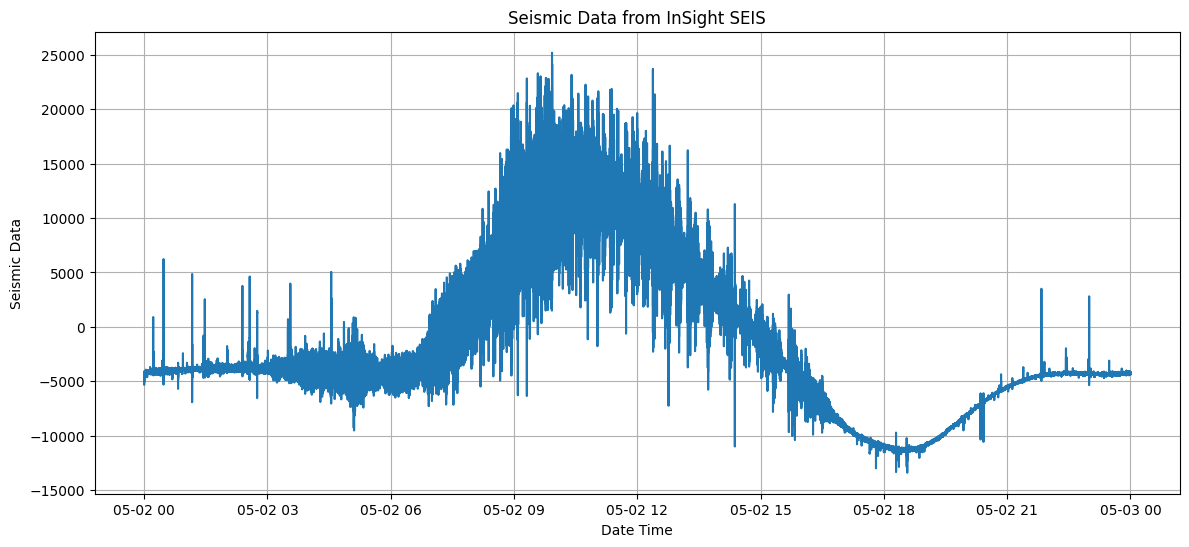

In [22]:
# Set column names
data.columns = ["Time", "Sample"]

# Plot the seismic data
plt.figure(figsize=(14, 6))
plt.plot(data["Time"], data["Sample"])
plt.xlabel("Date Time")
plt.ylabel("Seismic Data")
plt.title("Seismic Data from InSight SEIS")
plt.grid(True)
plt.show()